# FML - Exercise 2

In [331]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import griddata
from sklearn.datasets import load_digits

## 1. Data Preparation

In [332]:
digits = load_digits()

print(digits.keys())

data = digits["data"]
images = digits["images"]
target = digits["target"]
target_names = digits["target_names"]

mask = np.logical_or(target == 1, target == 7)
data = data[mask]
images = images[mask]
target = target[mask]

print(len(data))

train_size = round(len(data) * 3 / 5)
train_data = data[:train_size]
train_images = images[:train_size]
train_target = target[:train_size]
test_data = data[train_size:]
test_images = images[train_size:]
test_target = target[train_size:]

print(len(train_data) / len(test_data))

dict_keys(['data', 'target', 'frame', 'feature_names', 'target_names', 'images', 'DESCR'])
361
1.5069444444444444


### 1.1 Dimension Reduction

In [333]:
# compute the average 1 and 7 images

average_1 = np.mean(data[target == 1], axis=0)
average_7 = np.mean(data[target == 7], axis=0)

# find the two pixels with the largest difference between the two averages

distance = np.abs(average_1 - average_7)
features = np.argpartition(distance, -2)[-2:]

In [334]:
def reduce_dim(x):
    return x[:, features]

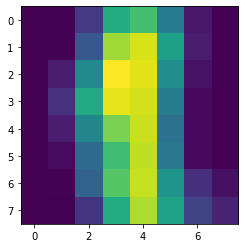

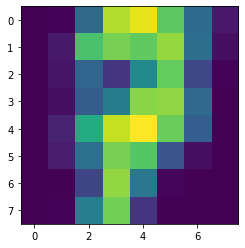

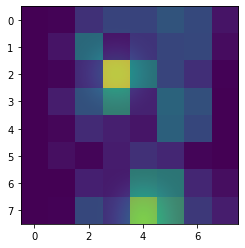

In [335]:
# Turn feature indices into boolean map
feature_map = np.reshape([index in features for index in range(len(average_1))], (8, 8))

# Show average of class 1
plt.imshow(np.reshape(average_1, (8, 8)))
plt.show()

# Show average of class 7
plt.imshow(np.reshape(average_7, (8, 8)))
plt.show()

# Show absolute differences of average images
plt.imshow(np.reshape(np.abs(average_7 - average_1), (8, 8)))
# Overlay feature map with different colormap
plt.imshow(feature_map, cmap=plt.cm.viridis, interpolation="bicubic", alpha=0.3)
plt.show()

### 1.2 Scatterplot

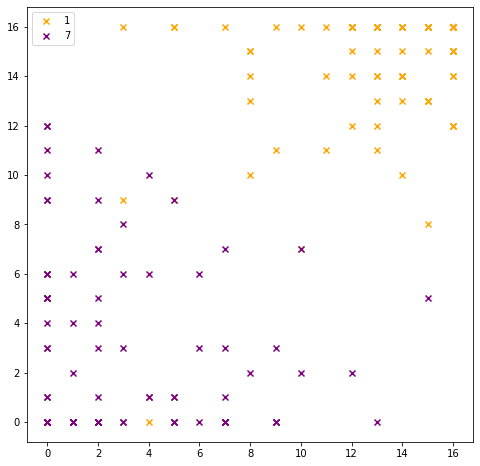

In [336]:
train_reduced = reduce_dim(train_data)
test_reduced = reduce_dim(test_data)

reduced_1 = train_reduced[train_target == 1]
reduced_7 = train_reduced[train_target == 7]

plt.figure(figsize=(8, 8))
plt.scatter(reduced_1[:, 0], reduced_1[:, 1], marker='x', color='orange', label='1')
plt.scatter(reduced_7[:, 0], reduced_7[:, 1], marker='x', color='purple', label='7')
plt.legend()
plt.show()

## 2. Nearest Mean
### 2.1 Implement the nearest mean classifier

In [337]:
def nearest_mean(training_features, training_labels, test_features):
    labels = np.array((1, 7))
    D = np.shape(training_features)[1]

    distances = np.zeros((len(test_features), len(labels)))

    for k, label in enumerate(labels):
        mean = np.mean(training_features[training_labels == label], axis=0)
        distances[:, k] = np.linalg.norm(test_features - mean, axis=1)

    return labels[np.argmin(distances, axis=1)]

### 2.2 Visualize the decision regions

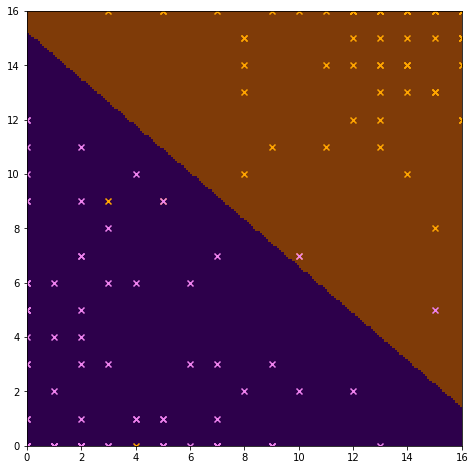

In [338]:
resolution = 200
maxfeature = 16

rang = np.arange(0, maxfeature, maxfeature / resolution)

grid = np.zeros((resolution, resolution))

for y_ind, y in enumerate(rang):
    test_set = np.vstack((rang, np.repeat(y, resolution))).transpose()
    grid[y_ind, :] = nearest_mean(reduce_dim(data), target, test_set)

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='PuOr', interpolation='nearest', origin='lower', extent=(0, maxfeature, 0, maxfeature))
plt.scatter(reduced_1[:, 0], reduced_1[:, 1], marker='x', color='orange', label='1')
plt.scatter(reduced_7[:, 0], reduced_7[:, 1], marker='x', color='violet', label='7')
plt.show()

## 3 QDA
### Implement QDA training

In [339]:
def fit_qda(training_features, training_labels):
    class_1 = training_features[training_labels == 1]
    class_7 = training_features[training_labels == 7]

    class_1_mean = np.mean(class_1, axis=0)
    class_7_mean = np.mean(class_7, axis=0)

    mean = np.array([class_1_mean, class_7_mean])

    class_1_cov = np.cov(class_1.transpose())
    class_7_cov = np.cov(class_7.transpose())

    covariance = np.array([class_1_cov, class_7_cov])

    class_1_prior = len(class_1) / (len(class_1) + len(class_7))
    class_7_prior = 1 - class_1_prior

    p = np.array([class_1_prior, class_7_prior])

    return mean, covariance, p


mu, covmat, p = fit_qda(train_reduced, train_target)

### Implement QDA Prediction

In [340]:
def predict_qda(mu, cm, p, test_features):
    mu_1 = mu[0]
    mu_7 = mu[1]

    covmat_1 = cm[0]
    covmat_7 = cm[1]

    covmat_1_inv = np.linalg.inv(covmat_1)
    covmat_7_inv = np.linalg.inv(covmat_7)

    p_1 = p[0]
    p_7 = p[1]

    test_dev_1 = test_features - mu_1
    test_dev_7 = test_features - mu_7

    b_1 = np.log(np.sqrt(np.linalg.det(2 * np.pi * covmat_1))) - np.log(p_1)
    b_7 = np.log(np.sqrt(np.linalg.det(2 * np.pi * covmat_7))) - np.log(p_7)

    p_y_1 = 0.5 * np.diag(test_dev_1 @ covmat_1_inv @ test_dev_1.transpose()) + b_1
    p_y_7 = 0.5 * np.diag(test_dev_7 @ covmat_7_inv @ test_dev_7.transpose()) + b_7

    p_y_bin = p_y_1 <= p_y_7

    p_y = p_y_bin + (1 - p_y_bin) * 7

    return p_y


train_predicted_labels = predict_qda(mu, covmat, p, train_reduced)
train_error = (train_predicted_labels - train_target) != 0
train_error_rate = np.sum(train_error) / len(train_predicted_labels)

test_predicted_labels = predict_qda(mu, covmat, p, test_reduced)
test_error = (test_predicted_labels - test_target) != 0
test_error_rate = np.sum(test_error) / len(test_predicted_labels)

print(f'Train error: {test_error_rate}')
print(f'Test error: {test_error_rate}')

Train error: 0.006944444444444444
Test error: 0.006944444444444444


### 3.3 Visualization

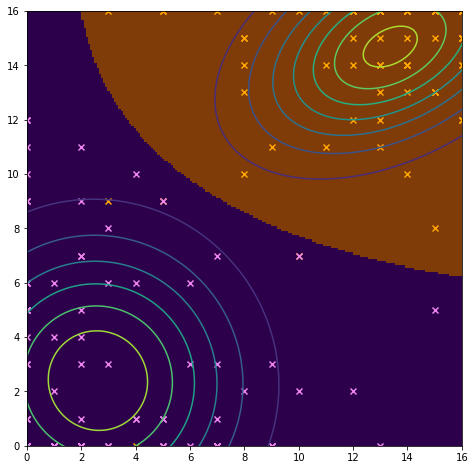

In [341]:
resolution = 200
maxfeature = 16

rang = np.arange(0, maxfeature, maxfeature / resolution)

grid = np.zeros((resolution, resolution))

for y_ind, y in enumerate(rang):
    test_set = np.vstack((rang, np.repeat(y, resolution))).transpose()
    grid[y_ind, :] = predict_qda(mu, covmat, p, test_set)

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='PuOr', interpolation='nearest', origin='lower', extent=(0, maxfeature, 0, maxfeature))
plt.scatter(reduced_1[:, 0], reduced_1[:, 1], marker='x', color='orange', label='1')
plt.scatter(reduced_7[:, 0], reduced_7[:, 1], marker='x', color='violet', label='7')


def gauss(mean, covariance_mat, XX):
    pos = np.empty(XX.shape + (2,))
    pos[:, :, 0] = XX
    pos[:, :, 1] = YY
    n = mean.shape[0]
    N = np.sqrt((2 * np.pi) ** n * np.linalg.det(covariance_mat))
    fac = np.einsum('...k,kl,...l->...', pos - mean, np.linalg.inv(covariance_mat), pos - mean)
    Z = np.exp(-fac / 2) / N
    return Z

a = np.arange(start=- 1, stop=16 + 1, step=0.1)
b = np.arange(start=- 1, stop=16 + 1, step=0.1)
XX, YY = np.meshgrid(a, b)

input_array = np.array([XX.ravel(), YY.ravel()]).T
labels_qda = predict_qda(mu, covmat, p, input_array)

Z1 = gauss(mu[0], covmat[0], XX)
Z2 = gauss(mu[1], covmat[1], XX)

plt.contour(XX, YY, Z1)
plt.contour(XX, YY, Z2)

plt.xlim(0, maxfeature)
plt.ylim(0, maxfeature)
plt.show()

TODO

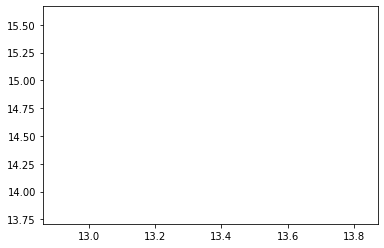

In [342]:
eigval, eigvec = np.linalg.eig(covmat[0])
vec_1 = mu[0] + eigvec[1]
vec_2 = mu[0] - eigvec[1]

plt.plot(vec_1[0], vec_1[1], vec_2[0], vec_2[1], c='b')


### 3.4 Performance



In [343]:
from sklearn.model_selection import KFold

def cross_validation(fit_func, predict_func):
    kfold = KFold(n_splits=10)

    reduced_data = reduce_dim(data)

    errors = []

    for train_i, test_i in kfold.split(reduced_data):
        train_x = reduced_data[train_i]
        train_y = target[train_i]

        test_x = reduced_data[test_i]
        test_y = target[test_i]

        mu, covmat, p = fit_func(train_x, train_y)

        pred_y = predict_func(mu, covmat, p, test_x)

        test_error = (pred_y - test_y) != 0
        test_error_rate = np.sum(test_error) / len(pred_y)
        errors.append(test_error_rate)

    error_mean = np.mean(errors)
    error_var = np.var(errors)
    error_dev = np.sqrt(error_var)

    print(f'Error: {error_mean} ± {error_dev}')

cross_validation(fit_qda, predict_qda)

Error: 0.019369369369369373 ± 0.032966080114472045


## 4 LDA

### 4.1 Implement LDA training

In [344]:
def fit_lda(training_features, training_labels):
    class_1 = training_features[training_labels == 1]
    class_7 = training_features[training_labels == 7]

    class_1_mean = np.mean(class_1, axis=0)
    class_7_mean = np.mean(class_7, axis=0)

    mean = np.array([class_1_mean, class_7_mean])

    cov = np.cov(training_features.transpose())
    covariance = np.array([cov, cov])

    class_1_prior = len(class_1) / (len(class_1) + len(class_7))
    class_7_prior = 1 - class_1_prior

    p = np.array([class_1_prior, class_7_prior])

    return mean, covariance, p


mu, covmat, p = fit_lda(train_reduced, train_target)

### 4.2 Implement LDA prediction

In [345]:
def predict_lda(mu, cm, p, test_features):
    predicted_labels = np.empty(len(test_features), dtype=int)

    for i in range(len(test_features)):
        y = np.zeros(mu.shape[0])

        for k in range(len(mu)):
            b_k = (1 / 2) * np.log(np.linalg.det(2 * np.pi * cm[k])) - np.log(p[k])
            b_k_prime = b_k + (1 / 2) * np.dot(mu[k], np.dot(np.linalg.inv(cm[k]), mu[k].T))
            y[k] = mu[k] @ (np.linalg.inv(cm[k]) @ test_features[i].T) - b_k_prime

            predicted_labels[i] = np.argmax(y)

    corr_pred = (1 - predicted_labels) + predicted_labels * 7
    return corr_pred


train_predicted_labels = predict_lda(mu, covmat, p, train_reduced)
train_error = (train_predicted_labels - train_target) != 0
train_error_rate = np.sum(train_error) / len(train_predicted_labels)

test_predicted_labels = predict_lda(mu, covmat, p, test_reduced)
test_error = (test_predicted_labels - test_target) != 0
test_error_rate = np.sum(test_error) / len(test_predicted_labels)

print(f'Train error: {test_error_rate}')
print(f'Test error: {test_error_rate}')

Train error: 0.013888888888888888
Test error: 0.013888888888888888


### 4.3 Visualization

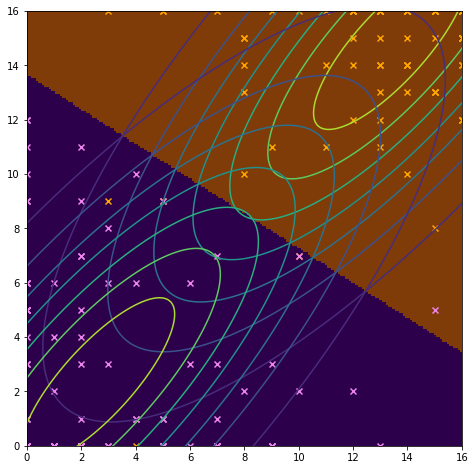

In [346]:
resolution = 200
maxfeature = 16

rang = np.arange(0, maxfeature, maxfeature / resolution)

grid = np.zeros((resolution, resolution))

for y_ind, y in enumerate(rang):
    test_set = np.vstack((rang, np.repeat(y, resolution))).transpose()
    grid[y_ind, :] = predict_lda(mu, covmat, p, test_set)

plt.figure(figsize=(8, 8))
plt.imshow(grid, cmap='PuOr', interpolation='nearest', origin='lower', extent=(0, maxfeature, 0, maxfeature))
plt.scatter(reduced_1[:, 0], reduced_1[:, 1], marker='x', color='orange', label='1')
plt.scatter(reduced_7[:, 0], reduced_7[:, 1], marker='x', color='violet', label='7')

a = np.arange(start=- 1, stop=16 + 1, step=0.1)
b = np.arange(start=- 1, stop=16 + 1, step=0.1)
XX, YY = np.meshgrid(a, b)

input_array = np.array([XX.ravel(), YY.ravel()]).T
labels_qda = predict_qda(mu, covmat, p, input_array)

Z1 = gauss(mu[0], covmat[0], XX)
Z2 = gauss(mu[1], covmat[1], XX)

plt.contour(XX, YY, Z1)
plt.contour(XX, YY, Z2)

plt.xlim(0, maxfeature)
plt.ylim(0, maxfeature)
plt.show()

TODO

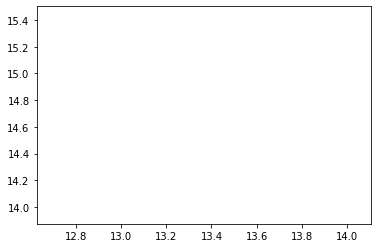

In [347]:
eigval, eigvec = np.linalg.eig(covmat[0])
vec_1 = mu[0] + eigvec[1]
vec_2 = mu[0] - eigvec[1]

plt.plot(vec_1[0], vec_1[1], vec_2[0], vec_2[1], c='b')

### 4.4 Performance Evaluation

In [348]:
cross_validation(fit_lda, predict_lda)


Error: 0.024924924924924926 ± 0.0289945344050859
